In [27]:
import math

import pandas as pd

import numpy as np

from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import mean_squared_error,root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, LassoLars

from catboost import CatBoostRegressor, Pool, cv

import optuna
from optuna.samplers import TPESampler

import joblib
file_path = "./optuna_journal_storage_final.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(file_path)
#
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(file_path, lock_obj=lock_obj),
)

from category_encoders import TargetEncoder




seed=42

# House Pricing

For this project, I'll be using the House Pricing dataset available on the Kaggle website. Let us start with the basics. 

In [ ]:
hp_df=pd.read_csv("train.csv")
test_set=pd.read_csv("test.csv")

## Data Understanding and Feature Engeneering

First we start by studying which features have the most missing values in them

In [29]:
na_df = pd.DataFrame({
    'Missing (%)': (hp_df.isnull().mean() * 100).round(2),
    'Missing Count': hp_df.isnull().sum()
}).sort_values(by='Missing (%)', ascending=False)
print(na_df[na_df["Missing (%)"]>0])


              Missing (%)  Missing Count
PoolQC              99.52           1453
MiscFeature         96.30           1406
Alley               93.77           1369
Fence               80.75           1179
MasVnrType          59.73            872
FireplaceQu         47.26            690
LotFrontage         17.74            259
GarageQual           5.55             81
GarageFinish         5.55             81
GarageType           5.55             81
GarageYrBlt          5.55             81
GarageCond           5.55             81
BsmtFinType2         2.60             38
BsmtExposure         2.60             38
BsmtCond             2.53             37
BsmtQual             2.53             37
BsmtFinType1         2.53             37
MasVnrArea           0.55              8
Electrical           0.07              1


Thus we will be removing the variables PoolQC, Alley, Fence and Miscfeature, and replacing them with a binary variable that indicates if the house has that feature (1) or not (0).

In [30]:
hp_df["HasPool"] = hp_df["PoolQC"].notna().astype(int)
hp_df["HasAlley"] = hp_df["Alley"].notna().astype(int)
hp_df["HasFence"] = hp_df["Fence"].notna().astype(int)
hp_df["HasMiscFeature"] = hp_df["MiscFeature"].notna().astype(int)
hp_df["IsRemodeled"]=hp_df["YearRemodAdd"].notna().astype(int)


hp_df = hp_df.drop(columns=["PoolQC", "MiscFeature", "Alley", "Fence"])

We will also be creating some new features that might help the models we will be creating predict the house prices.

In [31]:
hp_df["Grade"]=hp_df["OverallQual"]*hp_df["OverallCond"]




hp_df['Total_Bathrooms'] = (hp_df['FullBath'] + (0.5 * hp_df['HalfBath']) +
                               hp_df['BsmtFullBath'] + (0.5 * hp_df['BsmtHalfBath']))

hp_df['LotAreaRatio'] = np.where(hp_df['LotArea'].isna() | hp_df['LotFrontage'].isna() | (hp_df['LotFrontage']== 0),
                                    np.nan, (hp_df['LotArea']/hp_df['LotFrontage']))

hp_df["Bed_bath_ratio"]=hp_df["BedroomAbvGr"]/hp_df["Total_Bathrooms"]

hp_df["TimeSinceRemodel"]=hp_df["YrSold"]-hp_df["YearRemodAdd"]

hp_df["HouseAge"]=hp_df["YrSold"]-hp_df["YearBuilt"]


hp_df['TotalSF'] = hp_df['TotalBsmtSF'] + hp_df['1stFlrSF'] + hp_df['2ndFlrSF']

Since most of the feature don't have their datatype correctly assigned is up to us to do it.

In [32]:
hp_df[["OverallQual","OverallCond"]]=hp_df[["OverallQual","OverallCond"]].astype(pd.CategoricalDtype(categories=range(1, 11), ordered=True))
hp_df[["MSSubClass"]]=hp_df[["MSSubClass"]].astype(str)
hp_df[["MSSubClass"]]=hp_df[["MSSubClass"]].astype("category")


object_var=hp_df.loc[:,(hp_df.dtypes=="object")].columns
hp_df[object_var]=hp_df[object_var].fillna("Not Available")


hp_df[hp_df.loc[:,hp_df.dtypes=="object"].columns]=hp_df[hp_df.loc[:,hp_df.dtypes=="object"].columns].astype("category")



hp_df[["LotFrontage","MasVnrArea","GarageYrBlt"]]=hp_df[["LotFrontage","MasVnrArea","GarageYrBlt"]].fillna(0)


for i in hp_df.loc[:,hp_df.dtypes=="int64"].columns:
    hp_df[i]=hp_df[i].astype("float64")


categorical_var=hp_df.loc[:,(hp_df.dtypes=="category")].columns
numerical_variables=hp_df.drop(columns="SalePrice").loc[:,(hp_df.dtypes=="float64")].columns



As discussed in the report, some of our features might suffer from some form of skewness, to avoid getting skewed residuals and thus endengering linear models, we will be treating them beforehand.

In [33]:
skewness = []
zero_or_less= []

for col in hp_df.drop(columns="SalePrice").select_dtypes('float64').columns:
    skewness.append(hp_df[col].skew())
    zero_or_less.append((hp_df[col] <= 0).any())

skew_df = pd.DataFrame({"Skewness":skewness,"zero_or_less":zero_or_less}, index=hp_df.drop(columns="SalePrice").select_dtypes('float64').columns)

skew_df = skew_df.sort_values(by='Skewness', ascending=False)

filtered_skew_df = skew_df[skew_df['Skewness'] < 1]

collumns_to_transform=skew_df[(skew_df["Skewness"]>0.9)&(skew_df["zero_or_less"]==False)].index.tolist()
hp_df[collumns_to_transform] = hp_df[collumns_to_transform].apply(np.log)


Although there seems to be a lot of NANs in our data, they are an integral part of the data indicating the non-existence of a feature in the house. Thus it's easy to conclude that this data should be kept as it is.

Let's now focus on setting the data types correctly to avoid problems further on.

# Exploratory Data Analysis

In [34]:
hp_df["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

From this description we can see that, in our dataset, we have house prices, that go from relatively cheap to expensive.

C:\Users\corre\AppData\Local\Temp\ipykernel_14968\3933995441.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hp_df.groupby("OverallCond")["SalePrice"].mean().plot.bar()


<Axes: xlabel='OverallCond'>

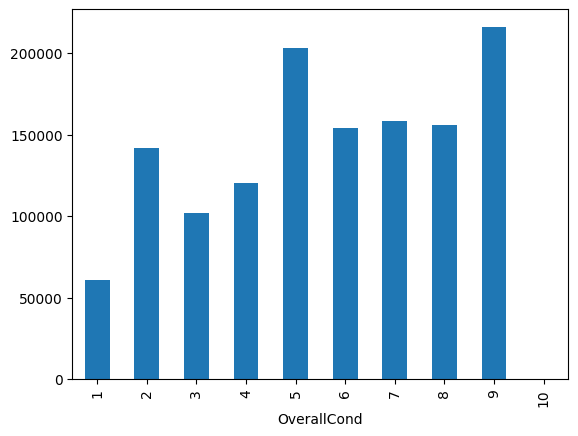

In [35]:
hp_df.groupby("OverallCond")["SalePrice"].mean().plot.bar()

C:\Users\corre\AppData\Local\Temp\ipykernel_14968\1326363709.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hp_df.groupby("OverallQual")["SalePrice"].mean().plot.bar()


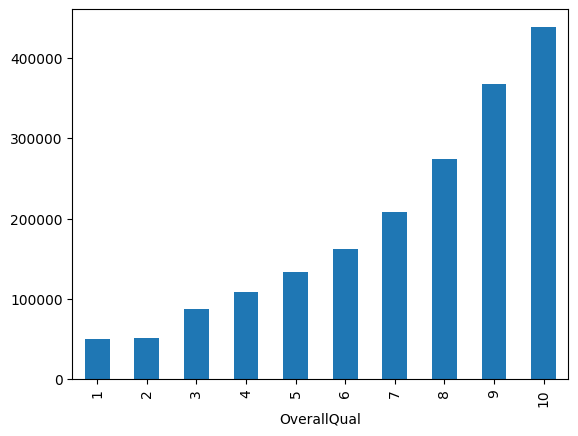

In [36]:
hp_df.groupby("OverallQual")["SalePrice"].mean().plot.bar()
hp_df[["OverallQual","OverallCond"]]=hp_df[["OverallQual","OverallCond"]].astype(pd.CategoricalDtype(categories=range(1, 11), ordered=True))

Unsuprisingly, there seems to exist a positive relation betwen the condition and the price of the house, the same for the quality with the relation being even stronger.

C:\Users\corre\AppData\Local\Temp\ipykernel_14968\1747562232.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hp_df.groupby("Neighborhood")["SalePrice"].mean().sort_values().plot.bar()


<Axes: xlabel='Neighborhood'>

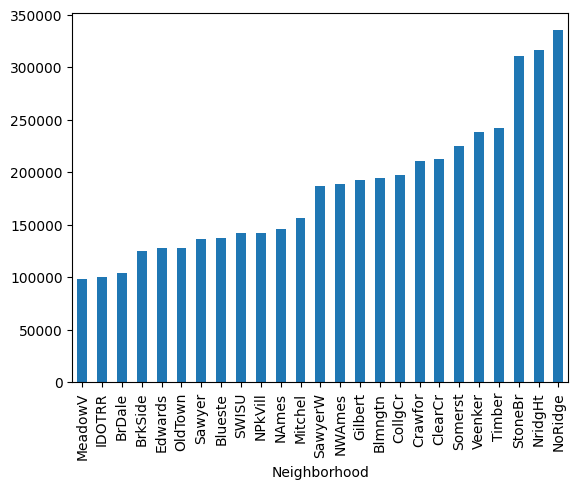

In [37]:
hp_df.groupby("Neighborhood")["SalePrice"].mean().sort_values().plot.bar()

C:\Users\corre\AppData\Local\Temp\ipykernel_14968\988522058.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hp_df.groupby("Neighborhood")["TotalSF"].mean().sort_values().plot.bar()


<Axes: xlabel='Neighborhood'>

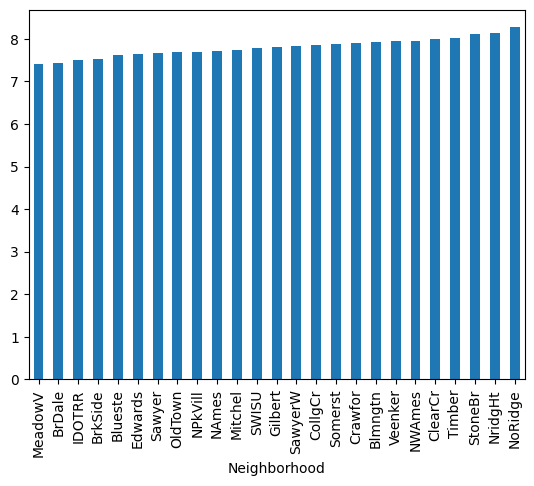

In [38]:
hp_df.groupby("Neighborhood")["TotalSF"].mean().sort_values().plot.bar()

The locations No Ridge, NridgHt and StoneBr are the most expensive ones to buy a house in. Given the non-existence of an uniformity in the values, this variable will most likely prove itself to be a usefull one in the long run.

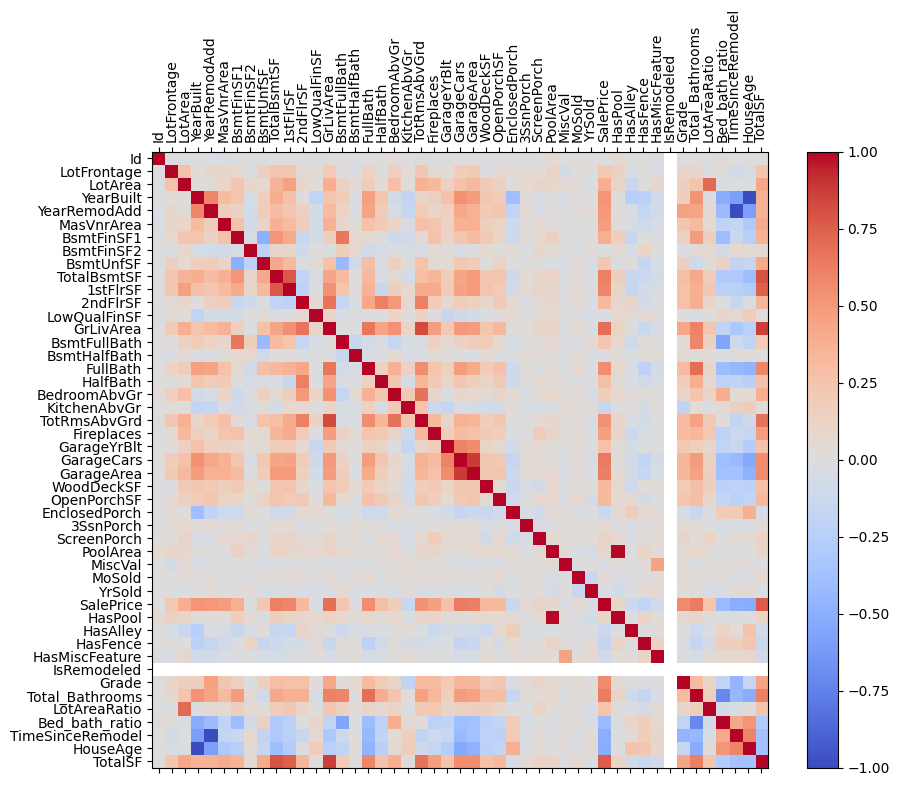

In [39]:
corr = hp_df.loc[:, hp_df.dtypes == "float64"].corr()

fig, ax = plt.subplots(figsize=(10, 8))

# Show the matrix with a fixed color scale
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
fig.colorbar(cax)

# Set ticks and labels
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

plt.show()

<Axes: xlabel='HasPool'>

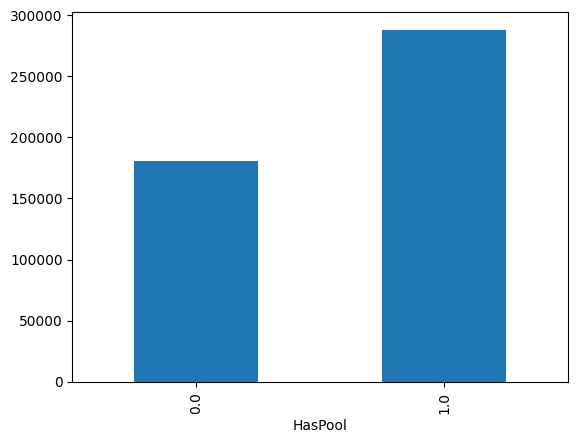

In [40]:
hp_df.groupby("HasPool")["SalePrice"].mean().sort_values().plot.bar()

As expected, the houses that possess a poll tend to be more expensive

C:\Users\corre\AppData\Local\Temp\ipykernel_14968\3530428162.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hp_df.groupby("Neighborhood")["BedroomAbvGr"].mean().sort_values().plot.bar()


<Axes: xlabel='Neighborhood'>

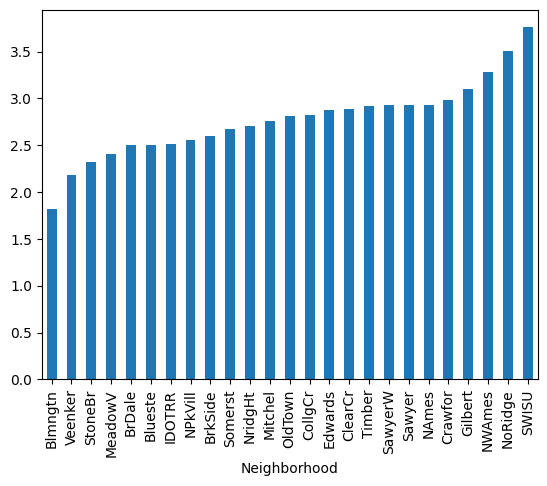

In [41]:
hp_df.groupby("Neighborhood")["BedroomAbvGr"].mean().sort_values().plot.bar()

<Axes: xlabel='BedroomAbvGr'>

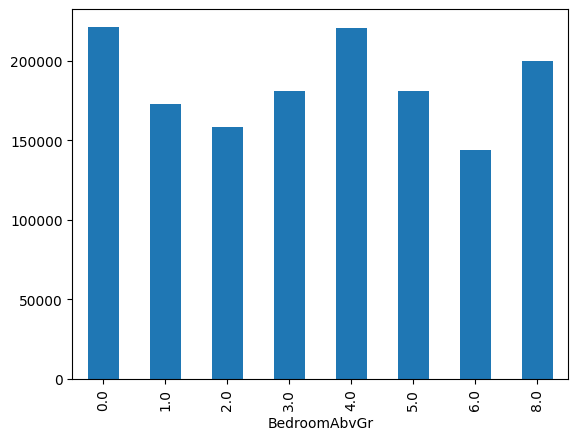

In [42]:
hp_df.sort_values(by="BedroomAbvGr").groupby("BedroomAbvGr")["SalePrice"].mean().plot.bar()

There doesn't seem to be a relation between the sale price and the number of bedrooms in the house. Its worth nothing that although houses without rooms might seem to be the most expensive ones there are only 6 of them in the whole dataset with prices ranging from 100k to 300k, and thus their mean is possible quite biased.

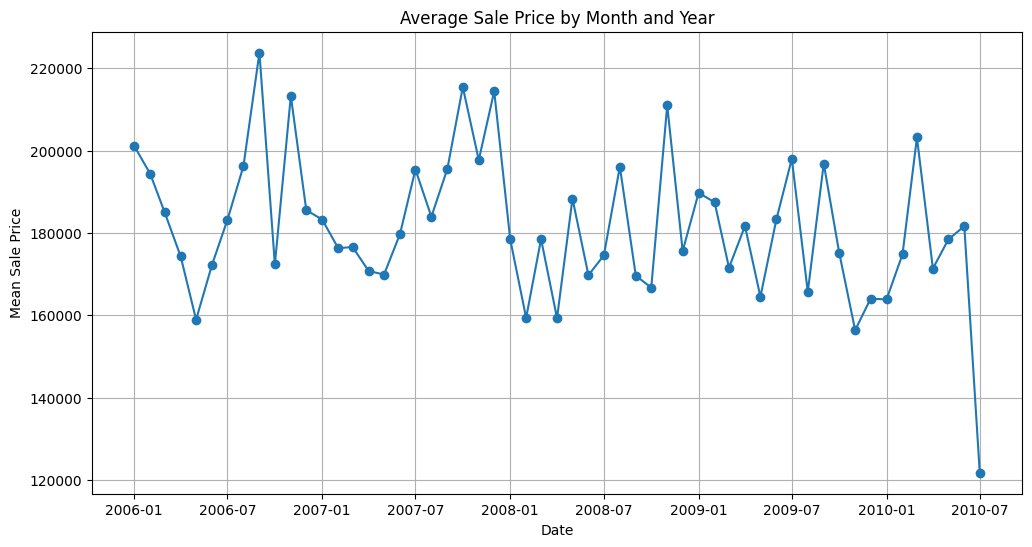

In [43]:
df=hp_df.copy()

df["SaleDate"] = pd.to_datetime(dict(year=df["YrSold"], month=df["MoSold"], day=1))

# group by month-year and calculate mean sale price
monthly_avg = df.groupby("SaleDate")["SalePrice"].mean()

# plot
plt.figure(figsize=(12,6))
plt.plot(monthly_avg.index, monthly_avg.values, marker="o")
plt.title("Average Sale Price by Month and Year")
plt.xlabel("Date")
plt.ylabel("Mean Sale Price")
plt.grid(True)
plt.show()

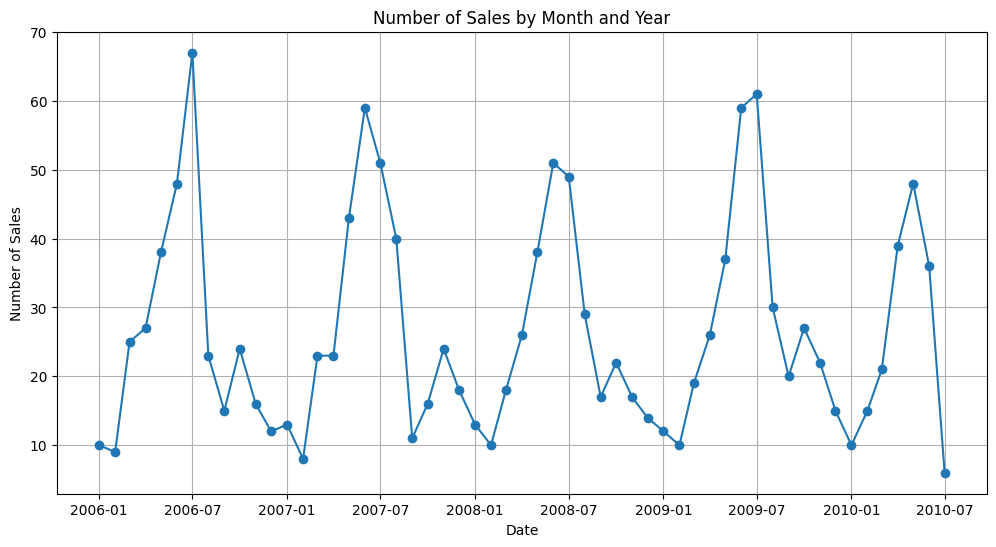

In [44]:
df=hp_df.copy()

df["SaleDate"] = pd.to_datetime(dict(year=df["YrSold"], month=df["MoSold"], day=1))

# group by month-year and calculate mean sale price
monthly_avg = df.groupby("SaleDate")["SalePrice"].size()

# plot
plt.figure(figsize=(12,6))
plt.plot(monthly_avg.index, monthly_avg.values, marker="o")
plt.title("Number of Sales by Month and Year")
plt.xlabel("Date")
plt.ylabel("Number of Sales")
plt.grid(True)
plt.show()

There does seem to be an increase in house prices in the second semester of the year. While there seems to be an increase in the first semester.

# Modeling

In [45]:
X=hp_df.drop(columns="SalePrice").copy()

y=np.log(hp_df["SalePrice"])

We'll be training on the whole dataset, since our dataset is not that big.

Now we need to apply the same transformations we did on the training dataset, on the test set.

In [ ]:

test_set["HasPool"] = test_set["PoolQC"].notna().astype(int)
test_set["HasAlley"] = test_set["Alley"].notna().astype(int)
test_set["HasFence"] = test_set["Fence"].notna().astype(int)
test_set["HasMiscFeature"] = test_set["MiscFeature"].notna().astype(int)
test_set["IsRemodeled"]=test_set["YearRemodAdd"].notna().astype(int)

test_set = test_set.drop(columns=["PoolQC", "MiscFeature", "Alley", "Fence"])


test_set["Grade"]=test_set["OverallQual"]*test_set["OverallCond"]


test_set[["OverallQual","OverallCond"]]=test_set[["OverallQual","OverallCond"]].astype(pd.CategoricalDtype(categories=range(1, 11), ordered=True))

for i in test_set.loc[:,test_set.dtypes=="int64"].columns:
    test_set[i]=test_set[i].astype("float64")

numerical_variables=test_set.loc[:,(test_set.dtypes=="float64")].columns

test_set[numerical_variables]=test_set[numerical_variables].fillna(0)

object_var=test_set.loc[:,(test_set.dtypes=="object")].columns
test_set[object_var]=test_set[object_var].fillna("Not Available")


test_set[test_set.loc[:,test_set.dtypes=="object"].columns]=test_set[test_set.loc[:,test_set.dtypes=="object"].columns].astype("category")


test_set[["LotFrontage","MasVnrArea","GarageYrBlt"]]=test_set[["LotFrontage","MasVnrArea","GarageYrBlt"]].fillna(0)

test_set['Total_Bathrooms'] = (test_set['FullBath'] + (0.5 * test_set['HalfBath']) +
                               test_set['BsmtFullBath'] + (0.5 * test_set['BsmtHalfBath']))

test_set['LotAreaRatio'] = np.where(test_set['LotArea'].isna() | test_set['LotFrontage'].isna() | (test_set['LotFrontage']== 0),
                                    np.nan, (test_set['LotArea']/test_set['LotFrontage']))

test_set["Bed_bath_ratio"]=test_set["BedroomAbvGr"]/test_set["Total_Bathrooms"]


test_set["TimeSinceRemodel"]=test_set["YrSold"]-test_set["YearRemodAdd"]

test_set["HouseAge"]=test_set["YrSold"]-test_set["YearBuilt"]

test_set['TotalSF'] = test_set['TotalBsmtSF'] + test_set['1stFlrSF'] + test_set['2ndFlrSF']

test_set[["MSSubClass","MoSold","YrSold"]]=test_set[["MSSubClass","MoSold","YrSold"]].astype(str)
test_set[["MSSubClass","MoSold","YrSold"]]=test_set[["MSSubClass","MoSold","YrSold"]].astype("category")

test_set[collumns_to_transform] = test_set[collumns_to_transform].apply(np.log)

test_set[["MSSubClass","MoSold","YrSold"]]=test_set[["MSSubClass","MoSold","YrSold"]].astype(str)
test_set[["MSSubClass","MoSold","YrSold"]]=test_set[["MSSubClass","MoSold","YrSold"]].astype("category")

for i in test_set.loc[:,test_set.dtypes=="int64"].columns:
    test_set[i]=test_set[i].astype("float64")

for i in test_set.loc[:,test_set.dtypes=="object"].columns:
    test_set[i]=test_set[i].astype("category")

X_test_set=test_set.drop(columns="Id")

In [47]:
X[["MSSubClass","MoSold","YrSold"]]=X[["MSSubClass","MoSold","YrSold"]].astype(str)
X[["MSSubClass","MoSold","YrSold"]]=X[["MSSubClass","MoSold","YrSold"]].astype("category")

categorical_var=X.loc[:,(X.dtypes=="category")].columns

numerical_variables=X.loc[:,(X.dtypes=="float64")].columns

X=X.drop(columns=["Id"])

train_pool = Pool(X, y, cat_features=categorical_var.tolist())


To simplify the code of each model, we will create a pipeline that scales the numeric features and Target encodes the categorical ones.

In [48]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
], verbose= False)

categorical_transformer = Pipeline([
    ('target_encoder', TargetEncoder(handle_missing="value", handle_unknown="value", min_samples_leaf=20,smoothing=10.0 )),
], verbose= False)

preprocessor = ColumnTransformer([
    ('num', numeric_transformer,X.select_dtypes(include = 'number').columns),
    ('cat', categorical_transformer, X.select_dtypes(include = ['object','category']).columns)
], verbose= False)

As explored in outr report, since we applied a logarithmic transformation on the SalePrice feature, we need to find the smearing factor to ensure that our results aren't being influenced by the Jensen's Inequality.

In [49]:
def smearing_factor(model, X, y, n_splits=5, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    residuals = []
    
    for tr, va in kf.split(X):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_va)
        residuals.extend(y_va - y_pred)
    
    return np.mean(np.exp(residuals))


## CatBoost

In [50]:


def objective(trial):
    params = {
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "task_type": "GPU",
        "devices": "0",
        "bootstrap_type": "Bayesian",
        "iterations": trial.suggest_int("iterations", 1500, 4500),    
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.08),
        "depth": trial.suggest_int("depth", 4, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 5.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),
        "leaf_estimation_method": trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise"]),
        "od_type": "Iter",
        "od_wait": trial.suggest_int("od_wait", 100, 300),
        "border_count": trial.suggest_int("border_count", 96, 255),  
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 4, 12),
    }


    cv_res = cv(
        params=params,
        pool=train_pool,
        fold_count=5,
        shuffle=True,
        partition_random_seed=32,
        verbose=False,
        early_stopping_rounds=50  
    )
    
    best_rmse = np.min(cv_res["test-RMSE-mean"])
    return best_rmse

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    storage=storage,
    study_name="CB_full_4.4.1",
    load_if_exists=True,
)
study.optimize(objective, n_trials=0, n_jobs=1)

best_params = study.best_params | {
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "task_type": "GPU",
    "devices": "0",
    "random_seed": 42,
    "verbose": False,
}

finalCB_model = CatBoostRegressor(**best_params)
print("Best CV result",study.best_value)
print("Best CV result's parameters",study.best_params)
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
residuals = []
    
for tr, va in kf.split(X):
    X_tr, X_va = X.iloc[tr], X.iloc[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]
    finalCB_model.fit(X_tr, y_tr,cat_features=categorical_var.tolist(),early_stopping_rounds=50,)
    y_pred = finalCB_model.predict(X_va)
    residuals.extend(y_va - y_pred)

smear_CB=np.mean(np.exp(residuals))

finalCB_model.fit(
    X, y,
    cat_features=categorical_var.tolist(),
    early_stopping_rounds=50,
)



[I 2025-09-13 00:36:10,680] Using an existing study with name 'CB_full_4.4.1' instead of creating a new one.


Best CV result 0.11759855349239282
Best CV result's parameters {'iterations': 2439, 'learning_rate': 0.023456863339091482, 'depth': 4, 'l2_leaf_reg': 0.10501236965993632, 'bagging_temperature': 4.783046454350946, 'random_strength': 1.0244049559535622, 'leaf_estimation_method': 'Newton', 'grow_policy': 'Depthwise', 'od_wait': 249, 'border_count': 96, 'one_hot_max_size': 5}


# XGBoost

In [51]:

def objective(trial):
    params = {
        "booster": "gbtree",
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "learning_rate": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "reg_alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 6000),
        "n_jobs": 1,
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    
    model = Pipeline([
        ("preprocessor", preprocessor),  
        ("regressor", XGBRegressor(**params,random_state=seed)),
    ])
    score=cross_val_score(model,X,y,scoring="neg_root_mean_squared_error",cv=kf).mean()


    return -score

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    storage=storage,
    study_name="XGB_full_4.4.1",
    load_if_exists=True,
)
study.optimize(objective, n_trials=0, n_jobs=-1)

best_params = study.best_params
print("Best CV result",study.best_value)
print("Best CV result's parameters",study.best_params)
finalXGB_model=Pipeline([
            ('preprocessing',preprocessor),
            ('training',XGBRegressor(**best_params,random_state=seed))],verbose=False
            )

smear_XGB = smearing_factor(finalXGB_model, X, y)



        
finalXGB_model.fit(X,y)
print("")


[I 2025-09-13 00:38:01,924] Using an existing study with name 'XGB_full_4.4.1' instead of creating a new one.


Best CV result 0.12320572820479583
Best CV result's parameters {'eta': 0.021694767960432525, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6119848676063705, 'colsample_bytree': 0.7073741110064101, 'gamma': 0.015145194988491815, 'lambda': 0.0018230746447687035, 'alpha': 0.009435428950164786, 'n_estimators': 5884}



## LightGBM

In [52]:
import warnings
warnings.filterwarnings("ignore", category=Warning)


def objective(trial):
    params = {
        "boosting_type": "gbdt",
        "objective": "regression",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 16, 300,log=True),
        "max_depth": trial.suggest_int("max_depth", 0, 16),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.5),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": 1,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 3000), 
        "n_jobs": 1,   

    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    
    model = Pipeline([
        ("preprocessor", preprocessor),  
        ("regressor", LGBMRegressor(**params,random_state=seed)),
    ])
    score=cross_val_score(model,X,y,scoring="neg_root_mean_squared_error",cv=kf).mean()


    return -score
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    storage=storage,
    study_name="LGBM_full_4.4.1",
    load_if_exists=True,
)
study.optimize(objective, n_trials=0, n_jobs=-1)

best_params = study.best_params.copy()
best_params.update(dict(n_jobs=1))
print("Best CV result",study.best_value)
print("Best CV result's parameters",study.best_params)
finalLGBM_model = Pipeline([
    ('preprocessing', preprocessor),
    ('training', LGBMRegressor(**best_params,random_state=seed,verbose=-1)),
])
smear_LGBM = smearing_factor(finalLGBM_model, X, y)
finalLGBM_model.fit(X, y)
print("")

[I 2025-09-13 00:38:26,894] Using an existing study with name 'LGBM_full_4.4.1' instead of creating a new one.


Best CV result 0.12184122928419112
Best CV result's parameters {'learning_rate': 0.011490278365170829, 'num_leaves': 22, 'max_depth': 9, 'min_child_samples': 5, 'min_split_gain': 0.00039481134225281605, 'feature_fraction': 0.6307670033877003, 'bagging_fraction': 0.6125616820179737, 'lambda_l1': 0.1126070576182746, 'lambda_l2': 0.01632963337283725, 'n_estimators': 1543}



## Gradient Boosting Regressor (GBR)

In [53]:

def objective(trial):
    params = {
        "loss": trial.suggest_categorical("loss", ["squared_error", "huber"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 300, 3000, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 0.0, 0.01),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    
    model = Pipeline([
        ("preprocessor", preprocessor),  
        ("regressor", GradientBoostingRegressor(**params,random_state=seed)),
    ])
    score=cross_val_score(model,X,y,scoring="neg_root_mean_squared_error",cv=kf).mean()


    return -score

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    storage=storage,
    study_name="gbr_full_4.4.1",
    load_if_exists=True,
)

study.optimize(objective, n_trials=0, n_jobs=-1)

best_params = study.best_params
print("Best CV result",study.best_value)
print("Best CV result's parameters",study.best_params)
finalGBR_model=Pipeline([
            ('preprocessing',preprocessor),
            ('training',GradientBoostingRegressor(**best_params,random_state=seed))]
            )
smear_GBR = smearing_factor(finalGBR_model, X, y)        
finalGBR_model.fit(X,y)
print("")

[I 2025-09-13 00:38:37,272] Using an existing study with name 'gbr_full_4.4.1' instead of creating a new one.


Best CV result 0.11839408045303164
Best CV result's parameters {'loss': 'huber', 'learning_rate': 0.019916388145948146, 'n_estimators': 781, 'subsample': 0.6000523143185507, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.00640103372985322, 'max_features': 'sqrt'}



# ElasticNet

As discussed in our report, there were features that were created especifically to help the linear models understand different relations between variables and help it in more extreme values. This values weren't used in the tree-based methods because after some testing they didn't return results good enough to justify the increase of the number of variables.

In [54]:
X_lin=X.copy()
X_lin["LuxuryFlag"] =(X_lin["GarageCars"]>=9) | (X_lin["TotalSF"] >= np.log(3500)) | (X_lin["HasPool"]==1) | (X_lin["Total_Bathrooms"]>7)
X_lin["LuxuryFlag"]=X_lin["LuxuryFlag"].astype("category")

X_lin["OverallQual"]=X_lin["OverallQual"].astype("int")

X_lin["AreaQual"]=X_lin["OverallQual"]*X_lin["GrLivArea"]
X_lin["GarageLux"]=X_lin["GarageCars"]*X_lin["GarageArea"]
X_lin["SpaceQual"]=X_lin["TotalSF"]*X_lin["OverallQual"]

X_lin[["OverallQual"]]=X_lin[["OverallQual"]].astype(pd.CategoricalDtype(categories=range(1, 11), ordered=True))





numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
], verbose= False)

categorical_transformer = Pipeline([
    ('target_encoder', TargetEncoder(handle_missing="value", handle_unknown="value", min_samples_leaf=20,smoothing=10.0 )),
], verbose= False)

preprocessor_linear = ColumnTransformer([
    ('num', numeric_transformer,X_lin.select_dtypes(include = 'number').columns),
    ('cat', categorical_transformer, X_lin.select_dtypes(include = ['object','category']).columns)
], verbose= False)

def objective(trial):
    params = {
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0),
        "max_iter": 10000,
    }


    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    
    model = Pipeline([
        ("preprocessor", preprocessor_linear),  
        ("regressor", ElasticNet(**params,random_state=seed)),
    ])
    score=cross_val_score(model,X_lin,y,scoring="neg_root_mean_squared_error",cv=kf).mean()


    return -score


study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    storage=storage,
    study_name="en_full_4.4.5",
    load_if_exists=True,
)
study.optimize(objective, n_trials=0, n_jobs=-1)

best_params = study.best_params 
print("Best CV result",study.best_value)
print("Best CV result's parameters",study.best_params)
finalEN_model=Pipeline([
            ('preprocessing',preprocessor_linear),
            ('training',ElasticNet(**best_params,random_state=seed))]
            )

smear_en=smearing_factor(finalEN_model,X_lin,y)


finalEN_model.fit(X_lin,y)

print("")

[I 2025-09-13 00:38:56,432] Using an existing study with name 'en_full_4.4.5' instead of creating a new one.


Best CV result 0.12730766393870022
Best CV result's parameters {'alpha': 2.2379056856779403e-05, 'l1_ratio': 0.0004653256255645055}



## LassoLars

In [55]:

def objective(trial):
    params = {
        "alpha": trial.suggest_float("alpha", 1e-5, 1.0, log=True),
        "fit_intercept": True,
        "max_iter": 1000,
    }


    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    
    model = Pipeline([
        ("preprocessor", preprocessor_linear),  
        ("regressor", LassoLars(**params,random_state=seed)),
    ])
    score=cross_val_score(model,X_lin,y,scoring="neg_root_mean_squared_error",cv=kf).mean()


    return -score


study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    storage=storage,
    study_name="LL_full_4.4.4",
    load_if_exists=True,
)
study.optimize(objective, n_trials=0, n_jobs=-1)

best_params = study.best_params 
print("Best CV result",study.best_value)
print("Best CV result's parameters",study.best_params)
finalLL_model=Pipeline([
            ('preprocessing',preprocessor_linear),
            ('training',LassoLars(**best_params,random_state=seed))]
            )
smear_ll=smearing_factor(finalLL_model,X_lin,y)
        
finalLL_model.fit(X_lin,y)

print("")

[I 2025-09-13 00:38:58,668] Using an existing study with name 'LL_full_4.4.4' instead of creating a new one.


Best CV result 0.12782543160336385
Best CV result's parameters {'alpha': 3.2011398666529126e-05}



## Support Vector Regression

In [56]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
def objective(trial):
    params = {
        'kernel' : trial.suggest_categorical("kernel", ["rbf", "linear"]),
        'C' : trial.suggest_float("C", 1e-3, 1e3, log=True),
        'epsilon' : trial.suggest_float("epsilon", 1e-4, 1.0, log=True),
        "shrinking": trial.suggest_categorical("shrinking", [True, False]),
        "tol": trial.suggest_float("tol", 1e-5, 5e-3, log=True),
        "max_iter": 200000,  
        "cache_size": 1000,       
    }

    if params['kernel'] == "rbf": 
        gamma_choice = trial.suggest_categorical("gamma_choice", ["scale", "auto", "float"])
        if gamma_choice == "float":
            params["gamma"] = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
        else:
            params["gamma"] = gamma_choice
    
    
    # Pipeline with feature scaling and target scaling
    base_model = SVR(**params)
    model = Pipeline([
        ("preprocessor", preprocessor_linear),  # your existing feature scaler/encoder
        ("tt", TransformedTargetRegressor(
            regressor=base_model,
            transformer=StandardScaler()  
        )),
    ])

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(
        model, X_lin, y,
        scoring="neg_root_mean_squared_error",
        cv=kf,
        n_jobs=1
    ).mean()

    return -score



study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    storage=storage,
    study_name="svr_full_4.4.5",
    load_if_exists=True,
)
study.optimize(objective, n_trials=0, n_jobs=-1)
print("Best CV result",study.best_value)
print("Best CV result's parameters",study.best_params)
best_params = study.best_params
if best_params['kernel'] == "rbf": 
    best_params.pop("gamma_choice")
finalSVR_model = Pipeline([
        ("preprocessor", preprocessor_linear),
        ("regressor", SVR(**best_params)),
    ])

smear_svr=smearing_factor(finalSVR_model,X_lin,y)


finalSVR_model.fit(X_lin,y)

print("")

[I 2025-09-13 00:39:00,643] Using an existing study with name 'svr_full_4.4.5' instead of creating a new one.


Best CV result 0.1295033941066555
Best CV result's parameters {'kernel': 'rbf', 'C': 100.64460346846268, 'epsilon': 0.000199052470074553, 'shrinking': True, 'tol': 0.00030537253581921847, 'gamma_choice': 'scale'}



# Ensemble

## Optuna approach

One of the ideas proposed was to use optuna to find the optimal weights for each model in the final ensemble. Altough it didn't prove to be the best value possible, it's still proved to be a useful and somewhat reliable approach. An expansion apon this idea could be a good way to improve our results in the future.

In [57]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Z_oof = pd.DataFrame(index=X_lin.index, columns=["cb","xgb","lgb","gbr","en","svr","ll"])

for tr, va in kf.split(X_lin):
    X_tr, X_va = X_lin.iloc[tr], X_lin.iloc[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]

    X_nonlinear=X_tr.drop(columns=["AreaQual","GarageLux","SpaceQual","LuxuryFlag"])
    X_va_nonlinear=X_va.drop(columns=["AreaQual","GarageLux","SpaceQual","LuxuryFlag"])

    # fresh copies each fold
    XGB_model = clone(finalXGB_model)
    LGBM_model = clone(finalLGBM_model)
    GBR_model  = clone(finalGBR_model)
    CB_model   = CatBoostRegressor(**finalCB_model.get_params())
    EN_model  = clone(finalEN_model)
    SVR_model  = clone(finalSVR_model)
    LL_model = clone(finalLL_model)

    XGB_model.fit(X_nonlinear, y_tr)
    LGBM_model.fit(X_nonlinear, y_tr)
    GBR_model.fit(X_nonlinear, y_tr)
    CB_model.fit(X_nonlinear, y_tr, cat_features=categorical_var.tolist())
    EN_model.fit(X_tr, y_tr)
    SVR_model.fit(X_tr, y_tr)
    LL_model.fit(X_tr,y_tr)



    # store OOF predictions
    Z_oof.loc[X_va.index, "xgb"] = XGB_model.predict(X_va_nonlinear).astype(float)
    Z_oof.loc[X_va.index, "lgb"] = LGBM_model.predict(X_va_nonlinear).astype(float)
    Z_oof.loc[X_va.index, "gbr"] = GBR_model.predict(X_va_nonlinear).astype(float)
    Z_oof.loc[X_va.index, "cb"]  = CB_model.predict(X_va_nonlinear).astype(float)
    Z_oof.loc[X_va.index, "en"] = EN_model.predict(X_va).astype(float)
    Z_oof.loc[X_va.index, "svr"] = SVR_model.predict(X_va).astype(float)
    Z_oof.loc[X_va.index, "ll"] = LL_model.predict(X_va).astype(float)



y_true = y.values

In [58]:
def objective(trial):
    v1 = trial.suggest_float("v1", 1e-9, 1 - 1e-9)
    v2 = trial.suggest_float("v2", 1e-9, 1 - 1e-9)
    v3 = trial.suggest_float("v3", 1e-9, 1 - 1e-9)
    v4 = trial.suggest_float("v4", 1e-9, 1 - 1e-9)
    v5 = trial.suggest_float("v5", 1e-9, 1 - 1e-9)
    v6 = trial.suggest_float("v6", 1e-9, 1 - 1e-9)
    w_cb  = v1
    w_xgb = (1 - v1) * v2
    w_lgb = (1 - v1) * (1 - v2) * v3
    w_gbr = (1 - v1) * (1 - v2) * (1 - v3) * v4
    w_en  = (1 - v1) * (1 - v2) * (1 - v3) * (1 - v4) * v5
    w_svr = (1 - v1) * (1 - v2) * (1 - v3) * (1 - v4) * (1 - v5) * v6   
    w_ll  = (1 - v1) * (1 - v2) * (1 - v3) * (1 - v4) * (1 - v5) * (1 - v6) 
    rmses = []

    weights = np.array([w_cb, w_xgb, w_lgb, w_gbr,w_en,w_svr,w_ll])

    price_pred = (np.exp(Z_oof["cb"].tolist())  * smear_CB * weights[0] +
              np.exp(Z_oof["xgb"].tolist()) * smear_XGB * weights[1] +
              np.exp(Z_oof["lgb"].tolist()) * smear_LGBM * weights[2] +
              np.exp(Z_oof["gbr"].tolist()) * smear_GBR * weights[3]+
              np.exp(Z_oof["en"].tolist()) * smear_en * weights[4]+
              np.exp(Z_oof["svr"].tolist()) * smear_svr * weights[5]+
              np.exp(Z_oof["ll"].tolist()) * smear_ll * weights[6])
    pred_log   = np.log(price_pred)

    return root_mean_squared_error(y_true, pred_log)



study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42),
    storage=storage,
    study_name="Weight_train_4.2",
    load_if_exists=True,
)
study.optimize(objective, n_trials=0, n_jobs=1)

v1 = study.best_params["v1"]; v2 = study.best_params["v2"]; v3 = study.best_params["v3"]; v4 = study.best_params["v4"]; v5 = study.best_params["v5"]; v6 = study.best_params["v6"]
best_weights = {
    "cb":  v1,
    "xgb": (1 - v1) * v2,
    "lgb": (1 - v1) * (1 - v2) * v3,
    "gbr": (1 - v1) * (1 - v2) * (1-v3) * v4,
    "en": (1 - v1) * (1 - v2) * (1-v3) * (1-v4)*v5,
    "svr": (1 - v1) * (1 - v2) * (1-v3) * (1-v4) * (1-v5) * v6,
    "ll": (1 - v1) * (1 - v2) * (1-v3) * (1-v4) * (1-v5) * (1-v6)
}
print(best_weights)


[I 2025-09-13 00:43:02,724] Using an existing study with name 'Weight_train_4.2' instead of creating a new one.


{'cb': 0.440914121746119, 'xgb': 0.0001453091372624041, 'lgb': 0.00018119501064793006, 'gbr': 0.5376457268847682, 'en': 0.020447682083570926, 'svr': 0.0004021736488931124, 'll': 0.0002637914887384663}


By using the general idea provided by the Optuna search we found, by trial and error, a set of weights that got us a RMSE score of 0.11832 on Kaggle

In [ ]:


test_pool= Pool(X_test_set, cat_features=categorical_var.tolist())
CB_prediction=np.exp(finalCB_model.predict(test_pool))*smear_CB
XGB_prediction=np.exp(finalXGB_model.predict(X_test_set))*smear_XGB
LGBM_prediction=np.exp(finalLGBM_model.predict(X_test_set))*smear_LGBM
GBR_prediction=np.exp(finalGBR_model.predict(X_test_set))*smear_GBR


X_test_set_lin=X_test_set.copy()
X_test_set_lin["LuxuryFlag"] =(X_test_set_lin["GarageCars"]>=9) | (X_test_set_lin["TotalSF"] >= np.log(3500)) | (X_test_set_lin["HasPool"]==1) | (X_test_set_lin["Total_Bathrooms"]>7)
X_test_set_lin["LuxuryFlag"]=X_test_set_lin["LuxuryFlag"].astype("category")

X_test_set_lin["OverallQual"]=X_test_set_lin["OverallQual"].astype("int")

X_test_set_lin["AreaQual"]=X_test_set_lin["OverallQual"]*X_test_set_lin["GrLivArea"]
X_test_set_lin["GarageLux"]=X_test_set_lin["GarageCars"]*X_test_set_lin["GarageArea"]
X_test_set_lin["SpaceQual"]=X_test_set_lin["TotalSF"]*X_test_set_lin["OverallQual"]

X_test_set_lin[["OverallQual"]]=X_test_set_lin[["OverallQual"]].astype(pd.CategoricalDtype(categories=range(1, 11), ordered=True))


EN_prediction=np.exp(finalEN_model.predict(X_test_set_lin))*smear_en
SVR_prediction=np.exp(finalSVR_model.predict(X_test_set_lin))*smear_svr
LL_prediction=np.exp(finalLL_model.predict(X_test_set_lin))*smear_ll

submission=pd.DataFrame({"Id":test_set["Id"],"SalePrice":np.round((0.25*CB_prediction+
                                                                   0.1*XGB_prediction+
                                                                   0.2*LGBM_prediction+
                                                                   0.35*GBR_prediction+
                                                                   0.1*LL_prediction+
                                                                   0*EN_prediction+
                                                                   0*SVR_prediction))})


In [60]:
submission["Id"]=submission["Id"].astype(int)
submission.to_csv("kaggle_result.csv",index=False)
